Configure Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/MyDrive/Style\ Transfer

/content/drive/MyDrive/Style Transfer


In [3]:
ls

bun1.JPG  bun3.jpg  bun.jpg     style2.JPG  style4.jpg
bun2.jpg  bun4.jpg  style1.JPG  style3.JPG  sunflower.JPG


Imports

In [4]:
import os
import tensorflow as tf

# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [5]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

Support Functions

In [6]:
def tensor_to_image(tensor):
  """Converting tensor object to PIL image"""

  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [7]:
def load_img(path_to_img):
  """Downloading and converting image to PIL image"""
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [8]:
def imshow(image, title=None):
  """Display image"""
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

Getting and displaying images

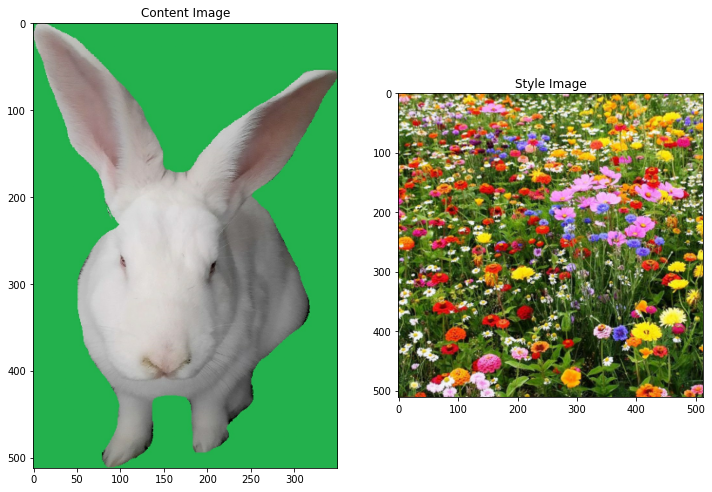

In [9]:
content_image = load_img("bun4.jpg")
style_image = load_img("style4.jpg")

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## VGG19 configuration

Loading VGG19 without classification head

In [10]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
print()
for layer in vgg.layers:
  print(layer.name)


input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Configuring style and content layers

In [11]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

Custom VGG loader with intermediate layers output

In [12]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

Creating model

In [13]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 512, 512, 64)
  min:  0.0
  max:  839.77295
  mean:  35.981888

block2_conv1
  shape:  (1, 256, 256, 128)
  min:  0.0
  max:  4458.411
  mean:  205.74864

block3_conv1
  shape:  (1, 128, 128, 256)
  min:  0.0
  max:  9725.207
  mean:  224.07855

block4_conv1
  shape:  (1, 64, 64, 512)
  min:  0.0
  max:  22653.785
  mean:  755.25433

block5_conv1
  shape:  (1, 32, 32, 512)
  min:  0.0
  max:  3866.863
  mean:  49.714836



## Style Calculation

It turns out, the style of an image can be described by the means and correlations across the different feature maps. Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations. This Gram matrix can be calculated for a particular layer as:



In [14]:
def gram_matrix(input_tensor):
  # TODO - understand this better + implement some averaging between styles
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

Exracting style and content from image

In [15]:
class StyleContentModel(tf.keras.models.Model):
  
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

Running

In [16]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0033193526
    max:  69452.23
    mean:  643.1674

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  217592.25
    mean:  9939.682

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  990909.3
    mean:  9333.895

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  6031175.5
    mean:  138583.81

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  49049.8
    mean:  939.3903

Contents:
   block5_conv2
    shape:  (1, 32, 21, 512)
    min:  0.0
    max:  729.6947
    mean:  10.625075


## Training loop

Running gradient descent

In [17]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)

In [18]:
def clip_0_1(image):
  """function to keep the pixel values between 0 and 1:"""
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [19]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [20]:
style_weight=1e-3
content_weight=1e4

In [21]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [22]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Running

....................................................................................................

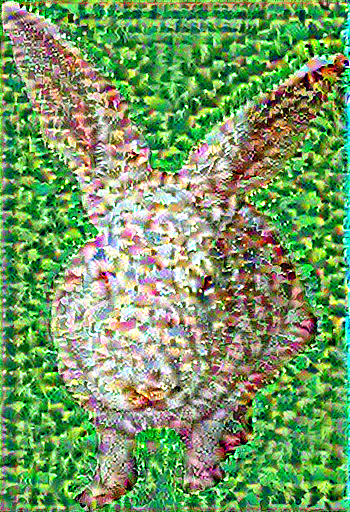

Train step: 100
....................................................................................................

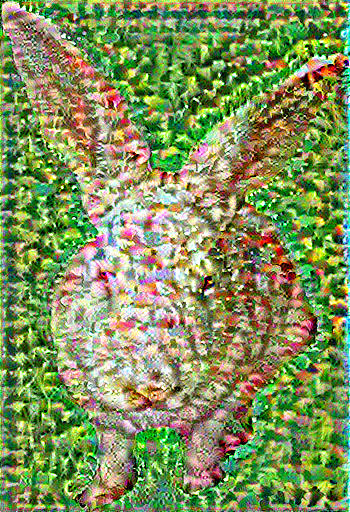

Train step: 200
....................................................................................................

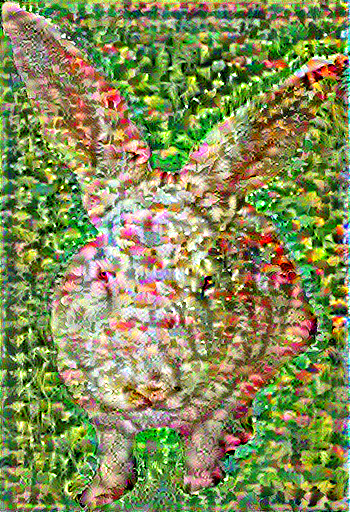

Train step: 300
....................................................................................................

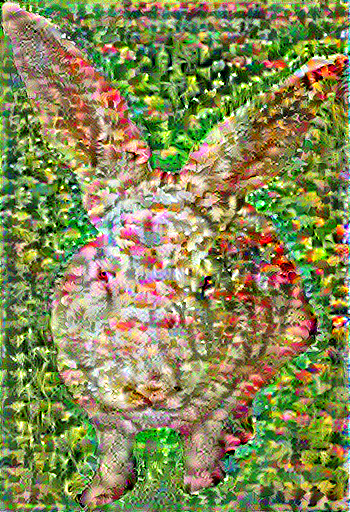

Train step: 400
....................................................................................................

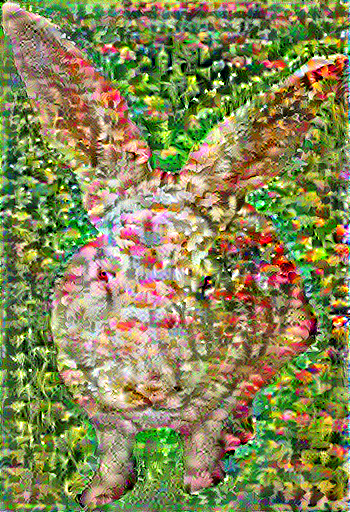

Train step: 500
....................................................................................................

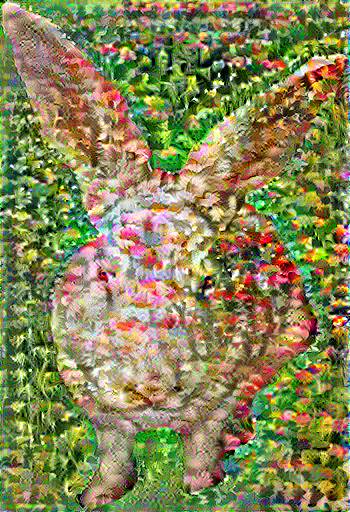

Train step: 600
....................................................................................................

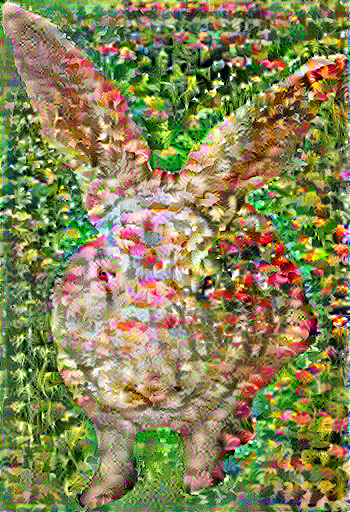

Train step: 700
....................................................................................................

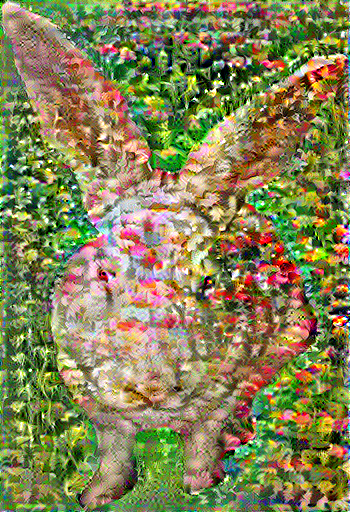

Train step: 800
....................................................................................................

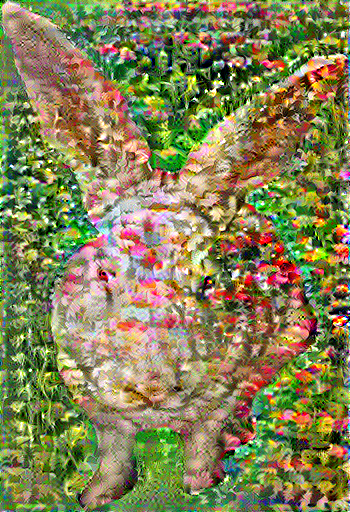

Train step: 900
....................................................................................................

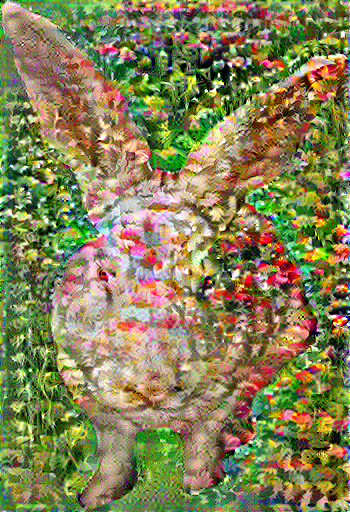

Train step: 1000
Total time: 23.8


In [23]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  #display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))